In [1]:
from copy import copy
from gymnasium.spaces import Discrete,MultiDiscrete
from pettingzoo import ParallelEnv

Environment

In [2]:
MOVES = {
    0: {"name": "save", "cost": -1, "type": "gain"},
    1: {"name": "defend", "cost": 0, "type": "defense"},
    2: {"name": "storm_defend", "cost": 0, "type": "defense"},
    3: {"name": "all_defend", "cost": 2, "type": "defense"},
    4: {"name": "sword", "cost": 1, "type": "attack"},
    5: {"name": "double_sword", "cost": 2, "type": "attack"},
    6: {"name": "storm", "cost": 3, "type": "attack"},
    7: {"name": "bomb", "cost": 5, "type": "attack"},
    8: {"name": "deflect", "cost": 1, "type": "defense"}
} # dict of moves
WIN_RULES = {
    # save
    (4, 0): "player1", (5, 0): "player1", (6, 0): "player1", (7, 0): "player1",
    (0, 4): "player2", (0, 5): "player2", (0, 6): "player2", (0, 7): "player2",
    # defend
    (6, 1): "player1", (7, 1): "player1",
    (1, 6): "player2", (1, 7): "player2",
    # storm_defend
    (4, 2): "player1", (5, 2): "player1", (7, 2): "player1",
    (2, 4): "player2", (2, 5): "player2", (2, 7): "player2",
    # sword
    (5, 4): "player1", (6, 4): "player1", (7, 4): "player1", (8, 4): "player1",
    (4, 5): "player2", (4, 6): "player2", (4, 7): "player2", (4, 8): "player2",
    # double_sword
    (6, 5): "player1", (7, 5): "player1",
    (5, 6): "player2", (5, 7): "player2",
    # storm
    (7, 6): "player1",
    (6, 7): "player2",
    # deflect
    (5,8): "player1", (6,8): "player1", (7,8): "player1",
    (8,5): "player1", (8,6): "player1", (8,7): "player1",
} # dict of winning combs

In [3]:
class CustomEnvironment(ParallelEnv): # creates custom environment
    metadata = {
        "name": "custom_environment_v0",
    }
    def __init__(self, maxsteps):
        # two agents, defining initial starting moves, points, action spaces and observation spaces
        self.move1 = None
        self.point1 = None
        self.move2 = None
        self.point2 = None
        self.timestep = None # starting timestep as 0
        self.maxsteps = maxsteps
        self.possible_agents = ["player1", "player2"]
        self.action_spaces = {a: Discrete(len(MOVES)) for a in self.possible_agents}
        self.observation_spaces = {a: MultiDiscrete([len(MOVES), 20, 20]) for a in self.possible_agents}
    def apply_move(self,action, player_points):
        move = MOVES[action]
        if move["cost"] == -1:  # save
            return action, player_points + 1
        elif player_points >= move["cost"]: #makes move
            return action, player_points - move["cost"]
        else:
            return 1, player_points#without points defends
    def reset(self, seed=None, options=None):
        self.agents=copy(self.possible_agents)
        self.timestep=0
        # when the game starts point is 0
        self.move1=1
        self.point1=0
        self.move2=1
        self.point2=0
        #define observations
        observations={
            a:(self.move1,self.point1,self.point2)
            for a in self.agents
        }
        infos={a:{} for a in self.agents}
        return observations,infos
    def step(self, actions):
        #applying the move
        self.move1, self.point1 = self.apply_move(actions["player1"], self.point1)
        self.move2, self.point2 = self.apply_move(actions["player2"], self.point2)
        rewards = {a: 0 for a in self.agents}
        #sets stopping value to 0
        terminations = {a: False for a in self.agents}
        truncations = {a: False for a in self.agents}
        winner = WIN_RULES.get((self.move1, self.move2)) # if both don't win, continue
        if winner == "player1":
            rewards = {"player1": 1, "player2": -1}
            terminations = {a: True for a in self.agents}
            print(f"P1Win")
            self.point1 = 0
            self.point2 = 0
        elif winner == "player2":
            rewards = {"player1": -1, "player2": 1}
            terminations = {a: True for a in self.agents}
            print(f"P2Win")
            self.point1 = 0
            self.point2 = 0
        else:
            truncations = {a: False for a in self.agents}
        self.timestep += 1
        if self.timestep > self.maxsteps:
            # stops the game if total steps goes over the maxstep count
            truncations = {"player1": True, "player2": True}
        observations = {a: (self.move1, self.point1, self.point2) for a in self.agents}
        # info for debugging, default in most envs
        infos = {a: {"p1_move": self.move1, "p2_move": self.move2,
            "p1_points": self.point1, "p2_points": self.point2,
            "winner": winner if any(terminations.values()) else None
        } for a in self.agents
        }
        return observations, rewards, terminations, truncations, infos
    def render(self):
        print(f"P1({self.point1} pts): {MOVES[self.move1]['name']}"
              f"P2({self.point2} pts): {MOVES[self.move2]['name']}")
    def observation_space(self, agent):
        return self.observation_spaces[agent]
    def action_space(self, agent):
        return self.action_spaces[agent]

Environment Testing

In [4]:
env = CustomEnvironment(100)
obs, infos = env.reset()

done = {a: False for a in env.agents}
step = 0
while not all(done.values()):
    # random simultaneous actions
    actions = {a: env.action_space(a).sample() for a in env.agents}
    obs, rewards, term, trunc, infos = env.step(actions)
    env.render()
    step += 1
    done = {a: term.get(a, False) or trunc.get(a, False) for a in env.possible_agents} 
print("Final rewards:", rewards)
print("Infos:", infos)


P1(0 pts): defendP2(0 pts): defend
P1(0 pts): defendP2(0 pts): defend
P1(0 pts): defendP2(0 pts): defend
P1(0 pts): defendP2(0 pts): storm_defend
P1(0 pts): defendP2(0 pts): defend
P1(0 pts): defendP2(0 pts): defend
P1(0 pts): storm_defendP2(0 pts): defend
P1(0 pts): defendP2(0 pts): storm_defend
P1(0 pts): storm_defendP2(0 pts): storm_defend
P1(0 pts): storm_defendP2(0 pts): defend
P1(0 pts): defendP2(0 pts): defend
P1(1 pts): saveP2(0 pts): defend
P1(1 pts): defendP2(1 pts): save
P1(2 pts): saveP2(1 pts): defend
P1(1 pts): swordP2(1 pts): defend
P1(1 pts): defendP2(1 pts): defend
P1(1 pts): defendP2(2 pts): save
P1(1 pts): defendP2(0 pts): all_defend
P1(0 pts): deflectP2(0 pts): defend
P1(0 pts): storm_defendP2(0 pts): defend
P1(0 pts): defendP2(0 pts): defend
P1(0 pts): defendP2(0 pts): defend
P1(0 pts): defendP2(0 pts): defend
P1(1 pts): saveP2(0 pts): defend
P1(0 pts): deflectP2(0 pts): defend
P1(0 pts): defendP2(0 pts): defend
P1(0 pts): defendP2(0 pts): storm_defend
P1(0 pts): d

Agent training via Q-table

Matplotlib is building the font cache; this may take a moment.


P2Win
P1Win
P2Win
P2Win
P1Win
P1Win
P1Win
P1Win
P1Win
P1Win
Episode 100/10000 | epsilon=0.606 | wins: player1=7, player2=3
Episode 200/10000 | epsilon=0.367 | wins: player1=7, player2=3
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Win
P2Wi

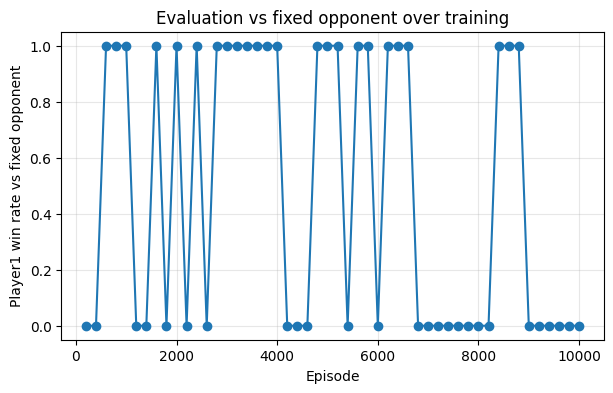

Eval 1 (both greedy): rewards={'player1': 0, 'player2': 0}, infos={'player1': {'p1_move': 0, 'p2_move': 0, 'p1_points': 1, 'p2_points': 1, 'winner': None}, 'player2': {'p1_move': 0, 'p2_move': 0, 'p1_points': 1, 'p2_points': 1, 'winner': None}}
Eval 2 (both greedy): rewards={'player1': 0, 'player2': 0}, infos={'player1': {'p1_move': 0, 'p2_move': 0, 'p1_points': 1, 'p2_points': 1, 'winner': None}, 'player2': {'p1_move': 0, 'p2_move': 0, 'p1_points': 1, 'p2_points': 1, 'winner': None}}
Eval 3 (both greedy): rewards={'player1': 0, 'player2': 0}, infos={'player1': {'p1_move': 0, 'p2_move': 0, 'p1_points': 1, 'p2_points': 1, 'winner': None}, 'player2': {'p1_move': 0, 'p2_move': 0, 'p1_points': 1, 'p2_points': 1, 'winner': None}}
Eval 4 (both greedy): rewards={'player1': 0, 'player2': 0}, infos={'player1': {'p1_move': 0, 'p2_move': 0, 'p1_points': 1, 'p2_points': 1, 'winner': None}, 'player2': {'p1_move': 0, 'p2_move': 0, 'p1_points': 1, 'p2_points': 1, 'winner': None}}
Eval 5 (both greedy)

In [5]:
# Q-learning for BOBO two-agent ParallelEnv
from collections import defaultdict
from typing import Dict
import numpy as np
import random
import matplotlib.pyplot as plt

# Use the previously defined BOBO environment
env = CustomEnvironment(100)
agent_names = env.possible_agents
n_actions = env.action_space(agent_names[0]).n

# ---- Helpers ----
# Mirror env.apply_move without mutating env

def apply_move_sim(action: int, points: int):
    m = MOVES[action]
    if m["cost"] == -1:
        return action, points + 1
    elif points >= m["cost"]:
        return action, points - m["cost"]
    else:
        return 1, points  # fallback to defend if not affordable

def state_key(obs_tuple):
    return tuple(int(x) for x in obs_tuple)

# Independent Q-tables per agent
Q = {a: defaultdict(lambda: np.zeros(n_actions, dtype=float)) for a in agent_names}

# Opponent action counts per state (for opponent-aware exploration)
opp_counts = {a: defaultdict(lambda: np.zeros(n_actions, dtype=float)) for a in agent_names}

def opponent_probs(agent: str, s) -> np.ndarray:
    counts = opp_counts[agent][s]
    probs = (counts + 1.0) / (np.sum(counts) + n_actions)  # Laplace smoothing
    return probs

def expected_immediate_reward(agent: str, obs_dict: Dict[str, tuple], a_self: int, opp_action_probs: np.ndarray) -> float:
    p1_pts = int(obs_dict['player1'][1])
    p2_pts = int(obs_dict['player2'][2])
    exp_r = 0.0
    for a_opp, p in enumerate(opp_action_probs):
        if p <= 0.0:
            continue
        if agent == 'player1':
            m_self, _ = apply_move_sim(a_self, p1_pts)
            m_opp, _ = apply_move_sim(a_opp, p2_pts)
            winner = WIN_RULES.get((m_self, m_opp))
        else:
            m_opp, _ = apply_move_sim(a_opp, p1_pts)
            m_self, _ = apply_move_sim(a_self, p2_pts)
            winner = WIN_RULES.get((m_opp, m_self))
        if winner is None:
            r = 0.0
        elif winner == agent:
            r = 1.0
        else:
            r = -1.0
        exp_r += p * r
    return exp_r

# Fixed opponent policy (for evaluation only)
# Greedy attack: spend points on the strongest affordable attack, else save

def fixed_opponent_action(points: int) -> int:
    for cost, act in [(5,7), (3,6), (2,5), (1,4)]:
        if points >= cost:
            return act
    return 0  # save

# Evaluation vs fixed opponent (player1 learns, player2 fixed)

def eval_vs_fixed(Q_tables, episodes=100, max_steps=200):
    env_eval = CustomEnvironment(env.maxsteps)
    wins = 0
    for _ in range(episodes):
        obs, _ = env_eval.reset()
        steps = 0
        while True:
            # player1 uses greedy Q, player2 uses fixed policy
            s1 = state_key(obs['player1'])
            p2_pts = int(obs['player2'][2])
            a1 = int(np.argmax(Q_tables['player1'][s1]))
            a2 = fixed_opponent_action(p2_pts)
            obs, rewards, terminations, truncations, infos = env_eval.step({'player1': a1, 'player2': a2})
            steps += 1
            if any(terminations.values()) or all(truncations.values()) or steps >= max_steps:
                if rewards.get('player1', 0.0) > rewards.get('player2', 0.0):
                    wins += 1
                break
    return wins / episodes if episodes > 0 else 0.0

# ---- Hyperparameters ----
episodes = 10000
alpha = 0.2
gamma = 0.95
epsilon_start, epsilon_end = 1.0, 0.02
epsilon_decay = 0.995
max_steps_per_episode = 200

# ---- Training loop with opponent-aware exploration ----
epsilon = epsilon_start
win_counts = {a: 0 for a in agent_names}

# Fixed-opponent evaluation tracking
hist_ep = []
hist_wr = []
eval_interval = 200
n_eval_episodes = 200

for ep in range(1, episodes + 1):
    obs, infos = env.reset()
    steps = 0
    while True:
        # Epsilon-greedy with opponent-aware exploration
        actions = {}
        states = {}
        for a in agent_names:
            s = state_key(obs[a])
            states[a] = s
            if random.random() < epsilon:
                opp_p = opponent_probs(a, s)
                exp_rewards = [expected_immediate_reward(a, obs, act, opp_p) for act in range(n_actions)]
                actions[a] = int(np.argmax(exp_rewards))
            else:
                actions[a] = int(np.argmax(Q[a][s]))

        next_obs, rewards, terminations, truncations, infos = env.step(actions)

        # Update opponent models
        for a in agent_names:
            s = states[a]
            opponent = 'player2' if a == 'player1' else 'player1'
            opp_counts[a][s][actions[opponent]] += 1.0

        # Q-updates for both agents
        for a in agent_names:
            s = states[a]
            a_idx = actions[a]
            r = float(rewards[a])
            s_next = state_key(next_obs[a])
            done_a = bool(terminations.get(a, False) or truncations.get(a, False))
            best_next = 0.0 if done_a else float(np.max(Q[a][s_next]))
            td_target = r + gamma * best_next
            Q[a][s][a_idx] += alpha * (td_target - Q[a][s][a_idx])

        obs = next_obs
        steps += 1
        if any(terminations.values()) or all(truncations.values()) or steps >= max_steps_per_episode:
            winners = set()
            for a in agent_names:
                w = infos.get(a, {}).get('winner')
                if w:
                    winners.add(w)
            for a in agent_names:
                if a in winners:
                    win_counts[a] += 1
            break

    # Decay exploration
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    # Periodic logging and evaluation
    if ep % 100 == 0:
        print(f'Episode {ep}/{episodes} | epsilon={epsilon:.3f} | wins: ' + ', '.join(f'{k}={v}' for k,v in win_counts.items()))
    if ep % eval_interval == 0:
        wr = eval_vs_fixed(Q, episodes=n_eval_episodes, max_steps=max_steps_per_episode)
        hist_ep.append(ep)
        hist_wr.append(wr)
        print(f'  Eval vs fixed opponent: win_rate={wr:.3f} over {n_eval_episodes} episodes')

# ---- Plot fixed-opponent win rate ----
plt.figure(figsize=(7,4))
plt.plot(hist_ep, hist_wr, marker='o')
plt.xlabel('Episode')
plt.ylabel('Player1 win rate vs fixed opponent')
plt.title('Evaluation vs fixed opponent over training')
plt.grid(True, alpha=0.3)
plt.show()

# ---- Final quick head-to-head greedy evaluation (both greedy Q) ----

def greedy_policy(obs_dict):
    actions = {}
    for a in agent_names:
        s = state_key(obs_dict[a])
        actions[a] = int(np.argmax(Q[a][s]))
    return actions

for i in range(5):
    obs, _ = env.reset()
    steps = 0
    while True:
        actions = greedy_policy(obs)
        obs, rewards, terminations, truncations, infos = env.step(actions)
        steps += 1
        if any(terminations.values()) or all(truncations.values()) or steps >= max_steps_per_episode:
            print(f'Eval {i+1} (both greedy): rewards={rewards}, infos={infos}')
            break


Agent testing

In [6]:
# Agent testing: 10 rounds, 50 steps max per round
# Uses minimax policies if available (Q_joint).
# Fallback: if Q_joint missing but independent Q exists, test greedy-vs-greedy.
import numpy as np, os, pickle
from collections import defaultdict

# Ensure action count from MOVES
N_ACT = len(MOVES)

# Helpers for minimax path (define if missing in session)
def _points_state(obs_dict):
    p1 = int(obs_dict['player1'][1]); p2 = int(obs_dict['player2'][2])
    return (p1, p2)

def _legal_mask(points):
    m = np.zeros(N_ACT, dtype=bool)
    for a, spec in MOVES.items():
        c = spec['cost']
        if c in (-1, 0) or points >= c:
            m[a] = True
    return m

def _solve_zero_sum_minimax(A, row_mask, col_mask, iters=200, eta=0.2):
    rows = np.where(row_mask)[0]; cols = np.where(col_mask)[0]
    if len(rows) == 0 or len(cols) == 0:
        x = np.zeros(N_ACT); y = np.zeros(N_ACT)
        if row_mask.sum(): x[row_mask] = 1.0 / row_mask.sum()
        if col_mask.sum(): y[col_mask] = 1.0 / col_mask.sum()
        return x, y, 0.0
    A_sub = A[np.ix_(rows, cols)]
    wx = np.ones(len(rows)); wy = np.ones(len(cols))
    x_avg = np.zeros_like(wx); y_avg = np.zeros_like(wy)
    for _ in range(iters):
        x = wx / wx.sum(); y = wy / wy.sum()
        pay_row = A_sub @ y; pay_col = A_sub.T @ x
        wx *= np.exp(eta * pay_row); wy *= np.exp(-eta * pay_col)
        x_avg += x; y_avg += y
    x = x_avg / max(1e-12, x_avg.sum()); y = y_avg / max(1e-12, y_avg.sum())
    v = float(x @ (A_sub @ y))
    x_full = np.zeros(N_ACT); y_full = np.zeros(N_ACT)
    x_full[rows] = x; y_full[cols] = y
    return x_full, y_full, v

def _load_q_joint_if_available():
    if 'Q_joint' in globals():
        return globals()['Q_joint']
    path = 'RL/bobo_minimax_q.pkl'
    if os.path.exists(path):
        with open(path, 'rb') as f:
            raw = pickle.load(f)
        Qj = defaultdict(lambda: np.zeros((N_ACT, N_ACT), dtype=float))
        for k, v in raw.items():
            Qj[k] = v
        print('Loaded Q_joint from', path)
        return Qj
    return None

def test_minimax_policies(Qj, rounds=10, max_steps=50, verbose=True):
    env_test = CustomEnvironment(max_steps)
    results = {'player1': 0, 'player2': 0, 'draw': 0}
    per_round = []
    for r in range(1, rounds + 1):
        obs, _ = env_test.reset(); winner = None; steps = 0
        for t in range(1, max_steps + 1):
            s = _points_state(obs); p1, p2 = s
            m1 = _legal_mask(p1); m2 = _legal_mask(p2)
            pi1, pi2, _ = _solve_zero_sum_minimax(Qj[s], m1, m2, iters=250, eta=0.2)
            a1 = int(np.random.choice(N_ACT, p=pi1)); a2 = int(np.random.choice(N_ACT, p=pi2))
            obs, rewards, terms, truncs, infos = env_test.step({'player1': a1, 'player2': a2})
            steps = t
            if any(terms.values()) or all(truncs.values()):
                winner = infos.get('player1', {}).get('winner'); break
        tag = 'draw' if winner is None else winner
        results[tag] += 1; per_round.append((r, tag, steps))
        if verbose:
            print(f'Round {r}: {tag} in {steps} steps')
    return results, per_round

def test_greedy_Q(Q_tables, rounds=10, max_steps=50, verbose=True):
    # Uses independent Q tables (earlier section) with greedy actions
    env_test = CustomEnvironment(max_steps)
    results = {'player1': 0, 'player2': 0, 'draw': 0}
    def _state_key(obs_tuple):
        return tuple(int(x) for x in obs_tuple)
    for r in range(1, rounds + 1):
        obs, _ = env_test.reset(); steps = 0; winner = None
        for t in range(1, max_steps + 1):
            a1 = int(np.argmax(Q_tables['player1'][_state_key(obs['player1'])]))
            a2 = int(np.argmax(Q_tables['player2'][_state_key(obs['player2'])]))
            obs, rewards, terms, truncs, infos = env_test.step({'player1': a1, 'player2': a2})
            steps = t
            if any(terms.values()) or all(truncs.values()):
                winner = infos.get('player1', {}).get('winner'); break
        tag = 'draw' if winner is None else winner
        results[tag] += 1
        if verbose:
            print(f'Round {r}: {tag} in {steps} steps')
    return results

# Decide which testing path to use
Qj = _load_q_joint_if_available()
if Qj is not None:
    summary, rounds = test_minimax_policies(Qj, rounds=10, max_steps=50, verbose=True)
    print('Summary over 10 rounds:', summary)
elif 'Q' in globals():
    summary = test_greedy_Q(Q, rounds=10, max_steps=50, verbose=True)
    print('Summary over 10 rounds (greedy Q vs greedy Q):', summary)
else:
    raise RuntimeError('No trained policies found. Run the training cell (Minimax-Q or Q-learning) first.')


Round 1: draw in 50 steps
Round 2: draw in 50 steps
Round 3: draw in 50 steps
Round 4: draw in 50 steps
Round 5: draw in 50 steps
Round 6: draw in 50 steps
Round 7: draw in 50 steps
Round 8: draw in 50 steps
Round 9: draw in 50 steps
Round 10: draw in 50 steps
Summary over 10 rounds (greedy Q vs greedy Q): {'player1': 0, 'player2': 0, 'draw': 10}


One round

In [7]:
# Render 3 rounds with both agents using greedy policies
# - If independent Q tables exist: greedy per-agent argmax.
# - Else if minimax Q_joint exists: take argmax action from each minimax distribution.
import numpy as np

def _state_key_local(obs_tuple):
    return tuple(int(x) for x in obs_tuple)

def run_greedy_rounds(rounds=3, max_steps=50, sample_minimax=True):
    env_show = CustomEnvironment(max_steps)
    use_independent = 'Q' in globals()
    use_minimax = ('Q_joint' in globals()) and not use_independent
    if not use_independent and not use_minimax:
        # Try to load saved minimax table
        try:
            import os, pickle
            path = 'RL/bobo_minimax_q.pkl'
            if os.path.exists(path):
                from collections import defaultdict
                Q_loaded = pickle.load(open(path, 'rb'))
                globals()['Q_joint'] = {k: v for k, v in Q_loaded.items()}
                use_minimax = True
                print('Loaded Q_joint from', path)
        except Exception as e:
            print('Could not load Q_joint:', e)
    print('Mode:', 'independent Q greedy' if use_independent else 'minimax argmax' if use_minimax else 'none')
    if not (use_independent or use_minimax):
        raise RuntimeError('No policy found. Train Minimax-Q or Q-learning first.')
    for r in range(1, rounds + 1):
        obs, _ = env_show.reset()
        print(f'\nRound {r}:')
        for t in range(1, max_steps + 1):
            if use_independent:
                a1 = int(np.argmax(Q['player1'][_state_key_local(obs['player1'])]))
                a2 = int(np.argmax(Q['player2'][_state_key_local(obs['player2'])]))
            else:
                # Minimax distributions -> choose actions (sample or argmax)
                s = (int(obs['player1'][1]), int(obs['player2'][2]))
                p1, p2 = s
                # Build masks and solve minimax using helpers from testing cell if present
                try:
                    m1 = _legal_mask(p1); m2 = _legal_mask(p2)
                    pi1, pi2, _ = _solve_zero_sum_minimax(Q_joint[s], m1, m2, iters=250, eta=0.2)
                except NameError:
                    # Define minimal versions inline
                    def _legal_mask_inline(points):
                        m = np.zeros(len(MOVES), dtype=bool)
                        for a, spec in MOVES.items():
                            c = spec['cost']
                            if c in (-1, 0) or points >= c:
                                m[a] = True
                        return m
                    def _solve_minimax_inline(A, row_mask, col_mask, iters=200, eta=0.2):
                        rows = np.where(row_mask)[0]; cols = np.where(col_mask)[0]
                        A_sub = A[np.ix_(rows, cols)]
                        wx = np.ones(len(rows)); wy = np.ones(len(cols))
                        x_avg = np.zeros_like(wx); y_avg = np.zeros_like(wy)
                        for _ in range(iters):
                            x = wx / wx.sum(); y = wy / wy.sum()
                            pay_row = A_sub @ y; pay_col = A_sub.T @ x
                            wx *= np.exp(eta * pay_row); wy *= np.exp(-eta * pay_col)
                            x_avg += x; y_avg += y
                        x = x_avg / max(1e-12, x_avg.sum()); y = y_avg / max(1e-12, y_avg.sum())
                        x_full = np.zeros(len(MOVES)); y_full = np.zeros(len(MOVES))
                        x_full[rows] = x; y_full[cols] = y
                        return x_full, y_full, float(x @ (A_sub @ y))
                    m1 = _legal_mask_inline(p1); m2 = _legal_mask_inline(p2)
                    pi1, pi2, _ = _solve_minimax_inline(Q_joint[s], m1, m2, iters=250, eta=0.2)
                if sample_minimax:
                    a1 = int(np.random.choice(len(pi1), p=pi1)); a2 = int(np.random.choice(len(pi2), p=pi2))
                else:
                    a1 = int(np.argmax(pi1)); a2 = int(np.argmax(pi2))
            obs, rewards, terms, truncs, infos = env_show.step({'player1': a1, 'player2': a2})
            env_show.render()
            if any(terms.values()) or all(truncs.values()):
                print('Outcome:', infos.get('player1', {}).get('winner', 'draw'), 'Rewards:', rewards)
                break

# Execute 3 greedy rounds with rendering (sample from minimax for variety)
run_greedy_rounds(rounds=3, max_steps=50, sample_minimax=True)


Mode: independent Q greedy

Round 1:
P1(1 pts): saveP2(1 pts): save
P1(2 pts): saveP2(0 pts): deflect
P1(1 pts): swordP2(0 pts): defend
P1(0 pts): swordP2(0 pts): defend
P1(1 pts): saveP2(1 pts): save
P1(2 pts): saveP2(0 pts): deflect
P1(1 pts): swordP2(0 pts): defend
P1(0 pts): swordP2(0 pts): defend
P1(1 pts): saveP2(1 pts): save
P1(2 pts): saveP2(0 pts): deflect
P1(1 pts): swordP2(0 pts): defend
P1(0 pts): swordP2(0 pts): defend
P1(1 pts): saveP2(1 pts): save
P1(2 pts): saveP2(0 pts): deflect
P1(1 pts): swordP2(0 pts): defend
P1(0 pts): swordP2(0 pts): defend
P1(1 pts): saveP2(1 pts): save
P1(2 pts): saveP2(0 pts): deflect
P1(1 pts): swordP2(0 pts): defend
P1(0 pts): swordP2(0 pts): defend
P1(1 pts): saveP2(1 pts): save
P1(2 pts): saveP2(0 pts): deflect
P1(1 pts): swordP2(0 pts): defend
P1(0 pts): swordP2(0 pts): defend
P1(1 pts): saveP2(1 pts): save
P1(2 pts): saveP2(0 pts): deflect
P1(1 pts): swordP2(0 pts): defend
P1(0 pts): swordP2(0 pts): defend
P1(1 pts): saveP2(1 pts): save
P

Shapley Value Iteration (zero-sum planning)

In [8]:
# Compute optimal value and mixed strategies via Shapley value iteration
# State: (p1_points, p2_points). Payoff: +1/-1 on terminal win, else 0.
# Transition: apply both moves' point costs/savings; clamp points to [0, P_MAX-1].
from collections import defaultdict
import numpy as np, math, os, pickle

N_ACT = len(MOVES)
P_MAX = 20  # plan over 0..19 points per player
GAMMA = 0.95

def _apply_move_sim(action: int, points: int):
    move = MOVES[action]
    if move['cost'] == -1:  # save
        return action, points + 1
    elif points >= move['cost']:
        return action, points - move['cost']
    else:
        return 1, points  # fallback to defend

def _legal_mask(points):
    mask = np.zeros(N_ACT, dtype=bool)
    for a, spec in MOVES.items():
        c = spec['cost']
        if c in (-1, 0) or points >= c:
            mask[a] = True
    return mask

def _solve_minimax(A, row_mask, col_mask, iters=300, eta=0.2):
    rows = np.where(row_mask)[0]; cols = np.where(col_mask)[0]
    if len(rows) == 0 or len(cols) == 0:
        xr = np.zeros(N_ACT); yc = np.zeros(N_ACT); v = 0.0
        if row_mask.any(): xr[row_mask] = 1.0 / row_mask.sum()
        if col_mask.any(): yc[col_mask] = 1.0 / col_mask.sum()
        return xr, yc, v
    A_sub = A[np.ix_(rows, cols)]
    wx = np.ones(len(rows)); wy = np.ones(len(cols))
    x_avg = np.zeros_like(wx); y_avg = np.zeros_like(wy)
    for _ in range(iters):
        x = wx / wx.sum(); y = wy / wy.sum()
        pay_row = A_sub @ y; pay_col = A_sub.T @ x
        wx *= np.exp(eta * pay_row); wy *= np.exp(-eta * pay_col)
        x_avg += x; y_avg += y
    x = x_avg / max(1e-12, x_avg.sum()); y = y_avg / max(1e-12, y_avg.sum())
    v = float(x @ (A_sub @ y))
    xr = np.zeros(N_ACT); yc = np.zeros(N_ACT)
    xr[rows] = x; yc[cols] = y
    return xr, yc, v

# Initialize V over finite state grid and strategy tables
states = [(p1, p2) for p1 in range(P_MAX) for p2 in range(P_MAX)]
V = {s: 0.0 for s in states}
PI1 = {s: np.ones(N_ACT) / N_ACT for s in states}
PI2 = {s: np.ones(N_ACT) / N_ACT for s in states}

def _build_stage_matrix(s, V_next):
    p1, p2 = s
    A = np.zeros((N_ACT, N_ACT), dtype=float)
    for a1 in range(N_ACT):
        m1, p1n = _apply_move_sim(a1, p1)
        for a2 in range(N_ACT):
            m2, p2n = _apply_move_sim(a2, p2)
            winner = WIN_RULES.get((m1, m2))
            if winner is None:
                p1c = max(0, min(P_MAX - 1, p1n))
                p2c = max(0, min(P_MAX - 1, p2n))
                A[a1, a2] = GAMMA * V_next[(p1c, p2c)]
            else:
                A[a1, a2] = 1.0 if winner == 'player1' else -1.0
    return A

def shapley_value_iteration(max_iters=500, tol=1e-4, verbose=True):
    global V, PI1, PI2
    for it in range(1, max_iters + 1):
        V_new = {}
        max_delta = 0.0
        for s in states:
            A = _build_stage_matrix(s, V)
            mask1 = _legal_mask(s[0]); mask2 = _legal_mask(s[1])
            pi1, pi2, v = _solve_minimax(A, mask1, mask2, iters=250, eta=0.2)
            V_new[s] = v
            PI1[s] = pi1; PI2[s] = pi2
            max_delta = max(max_delta, abs(v - V[s]))
        V = V_new
        if verbose and (it % 10 == 0 or it == 1):
            print(f'Iter {it}: max Δ={max_delta:.6f}')
        if max_delta < tol:
            if verbose:
                print(f'Converged in {it} iterations with max Δ={max_delta:.6f}')
            break
    return V, PI1, PI2

# Run Shapley value iteration
V, PI1, PI2 = shapley_value_iteration(max_iters=400, tol=1e-4, verbose=True)

# Save for reuse
os.makedirs('RL', exist_ok=True)
with open('RL/bobo_shapley_value.pkl', 'wb') as f:
    pickle.dump({'V': V, 'PI1': PI1, 'PI2': PI2}, f, protocol=pickle.HIGHEST_PROTOCOL)
print('Saved Shapley results to RL/bobo_shapley_value.pkl')

# Quick evaluation: sample from PI1/PI2 in the env
def eval_shapley_policies(rounds=10, max_steps=50, sample=True):
    env_eval = CustomEnvironment(max_steps)
    res = {'player1': 0, 'player2': 0, 'draw': 0}
    for r in range(1, rounds + 1):
        obs, _ = env_eval.reset()
        for t in range(1, max_steps + 1):
            s = (int(obs['player1'][1]), int(obs['player2'][2]))
            p1, p2 = s
            m1 = _legal_mask(p1); m2 = _legal_mask(p2)
            pi1 = PI1[s] * m1; pi2 = PI2[s] * m2
            if pi1.sum() == 0: pi1 = m1.astype(float)
            if pi2.sum() == 0: pi2 = m2.astype(float)
            pi1 = pi1 / pi1.sum(); pi2 = pi2 / pi2.sum()
            if sample:
                a1 = int(np.random.choice(N_ACT, p=pi1)); a2 = int(np.random.choice(N_ACT, p=pi2))
            else:
                a1 = int(np.argmax(pi1)); a2 = int(np.argmax(pi2))
            obs, rewards, term, trunc, infos = env_eval.step({'player1': a1, 'player2': a2})
            if any(term.values()) or all(trunc.values()):
                winner = infos.get('player1', {}).get('winner')
                res['draw' if winner is None else winner] += 1
                break
    return res

summary = eval_shapley_policies(rounds=10, max_steps=50, sample=True)
print('Shapley policy self-play (10 rounds):', summary)


Iter 1: max Δ=0.951768
Iter 10: max Δ=0.119644
Iter 20: max Δ=0.001290
Converged in 28 iterations with max Δ=0.000084
Saved Shapley results to RL/bobo_shapley_value.pkl
P1Win
P2Win
P2Win
P1Win
P2Win
P2Win
P2Win
P1Win
P1Win
P1Win
Shapley policy self-play (10 rounds): {'player1': 5, 'player2': 5, 'draw': 0}


In [9]:
# One-round playoff between Shapley agents with rendering
# Loads PI1/PI2 if not already in memory and plays 1 episode.
import os, pickle, numpy as np

def load_shapley_policies(path='RL/bobo_shapley_value.pkl'):
    global PI1, PI2, V
    if 'PI1' in globals() and 'PI2' in globals():
        return PI1, PI2
    with open(path, 'rb') as f:
        data = pickle.load(f)
    PI1 = data['PI1']; PI2 = data['PI2']; V = data.get('V', {})
    print('Loaded Shapley policies from', path)
    return PI1, PI2

def legal_mask(points):
    m = np.zeros(len(MOVES), dtype=bool)
    for a, spec in MOVES.items():
        c = spec['cost']
        if c in (-1, 0) or points >= c:
            m[a] = True
    return m

def shapley_playoff_one_round(max_steps=50, sample=True):
    PI1_local, PI2_local = load_shapley_policies()
    env = CustomEnvironment(max_steps)
    obs, _ = env.reset()
    for t in range(1, max_steps + 1):
        s = (int(obs['player1'][1]), int(obs['player2'][2]))
        p1, p2 = s
        m1 = legal_mask(p1); m2 = legal_mask(p2)
        pi1 = PI1_local[s] * m1; pi2 = PI2_local[s] * m2
        if pi1.sum() == 0: pi1 = m1.astype(float)
        if pi2.sum() == 0: pi2 = m2.astype(float)
        pi1 = pi1 / pi1.sum(); pi2 = pi2 / pi2.sum()
        if sample:
            a1 = int(np.random.choice(len(MOVES), p=pi1)); a2 = int(np.random.choice(len(MOVES), p=pi2))
        else:
            a1 = int(np.argmax(pi1)); a2 = int(np.argmax(pi2))
        obs, rewards, terms, truncs, infos = env.step({'player1': a1, 'player2': a2})
        env.render()
        if any(terms.values()) or all(truncs.values()):
            print('Outcome:', infos.get('player1', {}).get('winner', 'draw'), 'Rewards:', rewards)
            break

# Play one round now
shapley_playoff_one_round(max_steps=50, sample=True)


P1(1 pts): saveP2(1 pts): save
P1(1 pts): defendP2(1 pts): storm_defend
P1(2 pts): saveP2(1 pts): defend
P1(2 pts): defendP2(2 pts): save
P2Win
P1(0 pts): saveP2(0 pts): double_sword
Outcome: player2 Rewards: {'player1': -1, 'player2': 1}
